In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import seaborn as sns
from scipy.spatial.distance import cosine


import gensim
from gensim.models import Word2Vec

from transformers import BertTokenizer, BertModel, TFBertModel
import tensorflow_hub as hub
import tensorflow as tf

import nltk
from nltk.corpus import stopwords
from sklearn import manifold, decomposition
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import silhouette_score, adjusted_rand_score, confusion_matrix
from sklearn.cluster import KMeans
import re
import time

import sys
import os
import warnings
warnings.filterwarnings("ignore")

## Chargement des données

In [2]:
data = pd.read_csv('data_clean.csv')

In [3]:
data.head()

,uniq_id,product_name,image,description,product_category_tree,main_category,label_main_category,sub_category,description_clean
0,55b85ea15a1536d46b7190ad6fff8ce7,Elegance Polyester Multicolor Abstract Eyelet ...,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Key Features of Elegance Polyester Multicolor ...,Home Furnishing >> Curtains & Accessories,Home Furnishing,4,Curtains & Accessories,key features elegance polyester multicolor abs...
1,7b72c92c2f6c40268628ec5f14c6d590,Sathiyas Cotton Bath Towel,7b72c92c2f6c40268628ec5f14c6d590.jpg,Specifications of Sathiyas Cotton Bath Towel (...,Baby Care >> Baby Bath & Skin,Baby Care,0,Baby Bath & Skin,specifications sathiyas cotton bath towel bath...
2,64d5d4a258243731dc7bbb1eef49ad74,Eurospa Cotton Terry Face Towel Set,64d5d4a258243731dc7bbb1eef49ad74.jpg,Key Features of Eurospa Cotton Terry Face Towe...,Baby Care >> Baby Bath & Skin,Baby Care,0,Baby Bath & Skin,key features eurospa cotton terry face towel s...
3,d4684dcdc759dd9cdf41504698d737d8,SANTOSH ROYAL FASHION Cotton Printed King size...,d4684dcdc759dd9cdf41504698d737d8.jpg,Key Features of SANTOSH ROYAL FASHION Cotton P...,Home Furnishing >> Bed Linen,Home Furnishing,4,Bed Linen,key features santosh royal fashion cotton prin...
4,6325b6870c54cd47be6ebfbffa620ec7,Jaipur Print Cotton Floral King sized Double B...,6325b6870c54cd47be6ebfbffa620ec7.jpg,Key Features of Jaipur Print Cotton Floral Kin...,Home Furnishing >> Bed Linen,Home Furnishing,4,Bed Linen,key features jaipur print cotton floral king s...


# Étape 2 : Étudiez la faisabilité de classification en utilisant des techniques NLP plus avancées

Dans cette phase du projet, nous mettons en œuvre des techniques de NLP avancées en utilisant des embeddings de mots. Contrairement aux approches traditionnelles comme le Bag of Words et TF-IDF, les embeddings permettent une meilleure capture du contexte et des subtilités sémantiques des mots dans le texte. Par conséquent, nous omettons des étapes telles que le stemming et la lemmatisation, qui pourraient réduire la richesse sémantique nécessaire pour les embeddings. Nous nous concentrerons sur le nettoyage de base et la suppression des stopwords pour préparer nos données à l'utilisation de modèles d'embeddings tels que Word2Vec, BERT, et Universal Sentence Encoder.

## Section 1 :  Utilisation des embeddings :

## Word2Vec

Word2Vec est une technique populaire de modélisation des mots qui transforme les mots en vecteurs numériques en utilisant des réseaux de neurones. Cette technique capture la sémantique des mots en se basant sur leur contexte dans de grands corpus de texte. En utilisant Word2Vec, nous pouvons capter des relations sémantiques et syntaxiques entre les mots, ce qui est souvent omis dans les méthodes traditionnelles telles que BoW ou TF-IDF.

In [4]:
# Préparation des données : Tokenisation des descriptions nettoyées
sentences = [row.split() for row in data['description_clean']]

# Entraînement du modèle Word2Vec
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

### BERT (Bidirectional Encoder Representations from Transformers)

Contrairement aux modèles plus anciens, BERT prend en compte le contexte de chaque occurrence d'un mot dans le texte, ce qui lui permet de comprendre les subtilités linguistiques avec une précision beaucoup plus élevée.

In [5]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def get_bert_embedding_mean(text, tokenizer, model):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    outputs = model(**inputs)
    # Moyenne sur tous les tokens pour obtenir un seul vecteur par texte
    embeddings = outputs.last_hidden_state.mean(dim=1).detach().numpy()
    return embeddings

# Appliquer sur chaque description et créer une matrice
bert_embedings_matrix = np.array([get_bert_embedding_mean(text, tokenizer, model).squeeze() for text in data['description_clean']])

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

### Universal Sentence Encoder

Universal Sentence Encoder (USE) fournit des embeddings de phrases qui peuvent être utilisés dans une variété d'applications textuelles où les phrases sont comparées sémantiquement. Contrairement à Word2Vec ou BERT qui travaillent au niveau des mots ou des tokens, USE fournit directement des embeddings au niveau des phrases, simplifiant ainsi les tâches de comparaison sémantique.

In [6]:
# Charger le modèle USE depuis TensorFlow Hub
use_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

def get_use_embedding(text, use_model):
    return use_model([text])[0].numpy()

# Appliquer sur chaque description
use_matrix = np.array([get_use_embedding(text, use_model) for text in data['description_clean']])


## Vérification de la tokenisation pour Word2Vec :

In [7]:
# Afficher les 5 premiers éléments de 'sentences' pour vérifier la tokenisation
for sentence in sentences[:5]:
    print(sentence)

# Formation du modèle Word2Vec
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# Tester le modèle en recherchant les mots les plus similaires à un exemple donné
word = 'cotton'
if word in word2vec_model.wv:
    print("Les mots les plus similaires à '{}' sont :".format(word))
    print(word2vec_model.wv.most_similar(word))
else:
    print("Le mot '{}' n'est pas dans le vocabulaire du modèle.".format(word))


['key', 'features', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'floral', 'curtain', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'cm', 'height', 'pack', 'price', 'rs', 'curtain', 'enhances', 'look', 'interiors', 'curtain', 'made', 'high', 'quality', 'polyester', 'fabric', 'features', 'eyelet', 'style', 'stitch', 'metal', 'ring', 'makes', 'room', 'environment', 'romantic', 'loving', 'curtain', 'ant', 'wrinkle', 'anti', 'shrinkage', 'elegant', 'apparance', 'give', 'home', 'bright', 'modernistic', 'appeal', 'designs', 'surreal', 'attention', 'sure', 'steal', 'hearts', 'contemporary', 'eyelet', 'valance', 'curtains', 'slide', 'smoothly', 'draw', 'apart', 'first', 'thing', 'morning', 'welcome', 'bright', 'sun', 'rays', 'want', 'wish', 'good', 'morning', 'whole', 'world', 'draw', 'close', 'evening', 'create', 'special', 'moments', 'joyous', 'beauty', 'given', 'soothing', 'prints', 'bring', 'home', 'elegant', 'curtain', '

Les résultats semblent indiquer que le modèle Word2Vec fonctionne correctement, capturant des relations sémantiques pertinentes autour du mot **"cotton"**. Les mots les plus similaires à **"cotton"** sont des termes associés aux descriptions de **produits textiles** ou  **soin**, ce qui est attendu dans le contexte de nos données.

Quelques mots dans la liste des plus similaires, comme **"fit"**, **"type"**, **"regular"**, et **"machine",** pourraient sembler moins directement liés à **"cotton"** mais peuvent apparaître fréquemment avec ce mot dans des contextes spécifiques (comme **"machine washable cotton"**). Cela montre bien comment Word2Vec capte le contexte des mots basé sur leur co-occurrence.

##  Test avec BERT :

1. **Choix des Phrases :** Sélection de quelques phrases représentatives de notre dataset pour analyser comment BERT les encode.
2. **Génération des Embeddings :** Utilisez la fonction de BERT pour obtenir les embeddings de ces phrases et les examiner .
3. **Analyse de Similarité :** Calculez la similarité entre différentes phrases encodées pour voir comment BERT perçoit leur proximité sémantique.

In [8]:
# Phrases à analyser
text1 = "100% cotton dress"
text2 = "synthetic fiber garment"
text3 = "shirt color red"
text4 = "Washing type 30 degree"

# Obtenir les embeddings
embed1 = get_bert_embedding_mean(text1, tokenizer, model).squeeze()
embed2 = get_bert_embedding_mean(text2, tokenizer, model).squeeze()
embed3 = get_bert_embedding_mean(text3, tokenizer, model).squeeze()
embed4 = get_bert_embedding_mean(text4, tokenizer, model).squeeze()

# Calcul de la similarité cosine
similarity12 = 1 - cosine(embed1, embed2)
similarity13 = 1 - cosine(embed1, embed3)
similarity14 = 1 - cosine(embed1, embed4)

print(f"Similarité entre '{text1}' et '{text2}': {similarity12:.4f}")
print(f"Similarité entre '{text1}' et '{text3}': {similarity13:.4f}")
print(f"Similarité entre '{text1}' et '{text4}': {similarity14:.4f}")

Similarité entre '100% cotton dress' et 'synthetic fiber garment': 0.7636
Similarité entre '100% cotton dress' et 'shirt color red': 0.6876
Similarité entre '100% cotton dress' et 'Washing type 30 degree': 0.7288


## Test du chargement et l'application de l'Universal Sentence Encoder (USE)

1. **Chargement du Modèle :** Vérifier que le modèle USE est chargé correctement depuis TensorFlow Hub.
2. **Calcul des Embeddings :** Appliquer le modèle pour obtenir des embeddings à partir de quelques exemples de descriptions textuelles.
3. **Vérification des Résultats :** Examiner les embeddings générés pour s'assurer qu'ils sont de la forme attendue et qu'ils reflètent bien le contenu des textes.

In [9]:
# Exemples de descriptions pour tester les embeddings
descriptions = [
    "Flipkart.com: Buy Engage Rush , Jump Combo Set for Rs. from Flipkart.com. - Lowest Prices, Only Genuine Products, 30 Day Replacement Guarantee, Free Shipping. Cash On Delivery!",
    "Buy Eurospa Cotton Terry Face Towel Set for Rs. online. Eurospa Cotton Terry Face Towel Set at best prices with FREE shipping & cash on delivery. Only Genuine Products. 30 Day Replacement Guarantee."
]

# Calcul des embeddings pour les exemples donnés
embeddings = [get_use_embedding(desc, use_model) for desc in descriptions]

# Affichage des résultats pour vérifier
for i, embedding in enumerate(embeddings):
    print(f"Embedding {i+1} shape: {embedding.shape} - First 5 values: {embedding[:5]}")

Embedding 1 shape: (512,) - First 5 values: [-0.01812908 -0.07984424  0.00997086  0.00629711  0.02184289]
Embedding 2 shape: (512,) - First 5 values: [-0.05593703 -0.05931723 -0.01530571  0.01872221  0.04257472]


## Transition vers des Techniques de NLP Avancées

Dans le cadre de cette nouvelle phase, nous allons nous concentrer sur l'utilisation des embeddings de mots pour capturer les nuances contextuelles et sémantiques des descriptions de produits. Cela marque un changement par rapport aux méthodes traditionnelles basées sur les fréquences de mots, comme BoW et TF-IDF, qui ne capturent pas les relations entre les mots au-delà de leur cooccurrence dans les documents.

### Objectifs avec les Embeddings :
- **Explorer les relations sémantiques** : Utiliser des embeddings pour identifier comment les mots et les phrases sont liés dans un contexte multidimensionnel.
- **Visualisation des données** : Appliquer des techniques de réduction de dimension pour visualiser les structures et patterns cachés dans les données textuelles.
- **Amélioration de la Classification** : Utiliser les vecteurs d'embeddings comme caractéristiques d'entrée pour des modèles de classification plus sophistiqués.

En conséquence, nous allons retirer les sections précédentes sur l'analyse des fréquences de mots et nous concentrer sur les approches qui exploitent pleinement les capacités des modèles d'embeddings modernes.


## Section 2 : Méthodes de réduction de dimension sur le texte encodé

### Préparation des Vecteurs d'Embeddings :

#### Word2Vec  :

In [10]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list) < 1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

# Appliquer sur chaque description
wv_matrix = np.array([get_average_word2vec(tokens, word2vec_model.wv) for tokens in sentences])

### Mise en place des PCA et t-SNE pour chaque matrice d'embeddings

In [11]:
# Fonction pour appliquer PCA et t-SNE
def apply_pca_tsne(embeddings_matrix, n_components_pca=0.99, n_components_tsne=2, perplexity=30, n_iter=1000):
    print(embeddings_matrix.shape)
    pca = decomposition.PCA(n_components=n_components_pca)
    reduced_pca= pca.fit_transform(embeddings_matrix)
    print(reduced_pca.shape)

    # t-SNE
    temps1 = time.time()

    tsne = manifold.TSNE(n_components=n_components_tsne, perplexity=perplexity, n_iter=n_iter, init='random', random_state=6)
    reduced_tsne = tsne.fit_transform(reduced_pca)

    duration1=time.time()-temps1
    print(f"Temps de T-SNE : {duration1:15.2f} secondes")

    return reduced_pca, reduced_tsne

In [12]:
# Appliquer PCA et t-SNE pour chaque matrice d'embeddings
wv_pca, wv_tsne = apply_pca_tsne(wv_matrix)
bert_pca, bert_tsne = apply_pca_tsne(bert_embedings_matrix)
use_pca, use_tsne = apply_pca_tsne(use_matrix)

(1050, 100)
(1050, 4)
Temps de T-SNE :            7.03 secondes
(1050, 768)
(1050, 318)
Temps de T-SNE :            8.25 secondes
(1050, 512)
(1050, 322)
Temps de T-SNE :            8.28 secondes


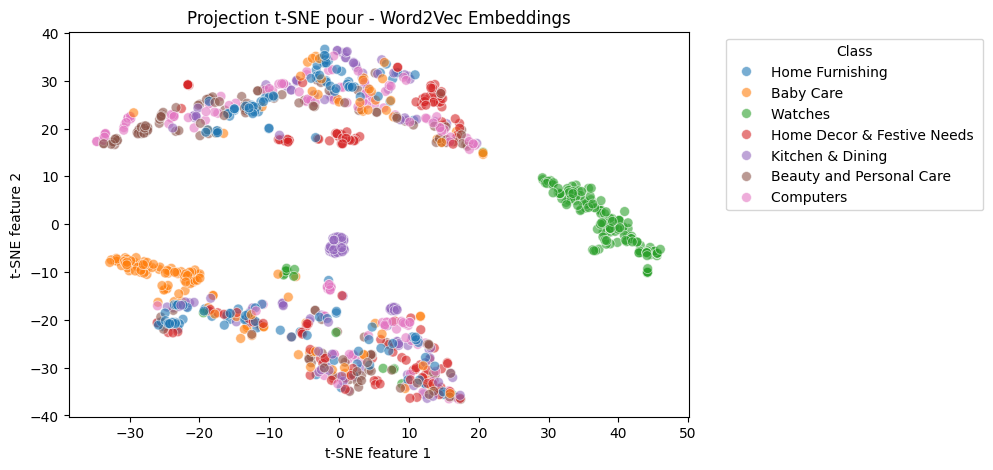

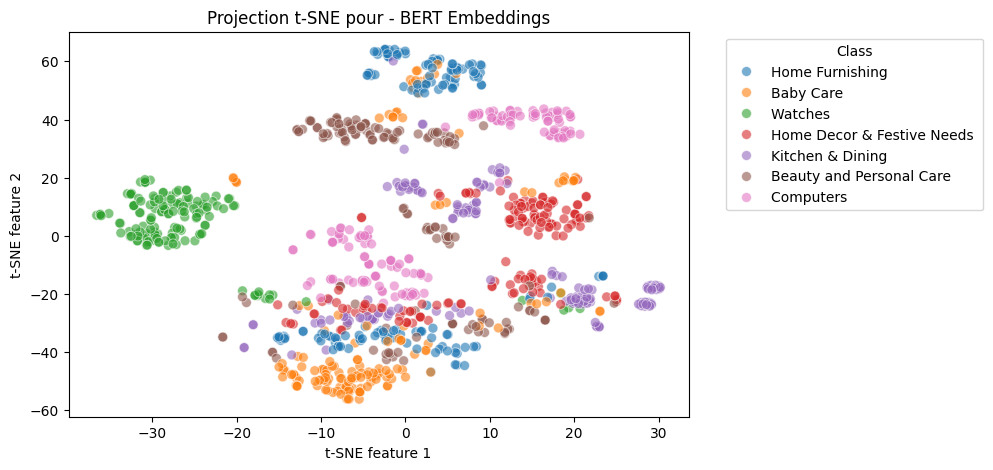

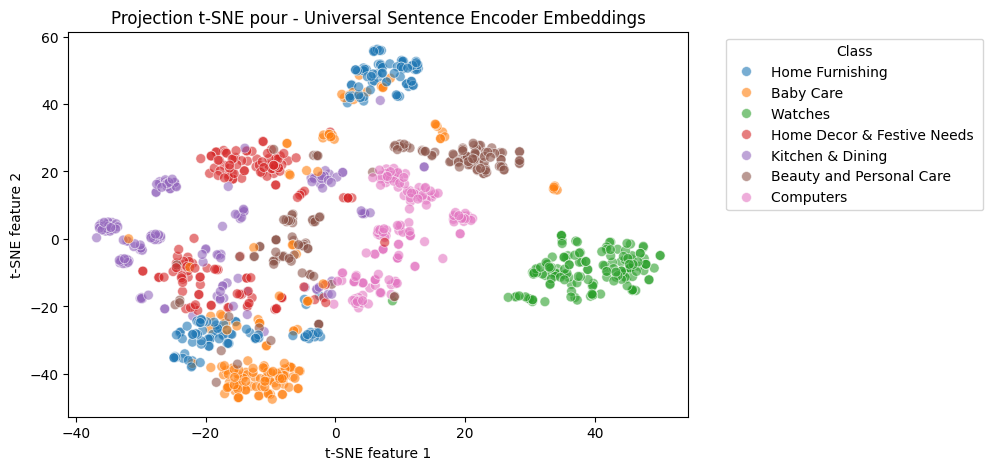

In [13]:
# Fonction pour tracer les graphiques t-SNE
def plot_tsne(X_tsne, title):
    df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
    df_tsne["class"] = data["main_category"]

    plt.figure(figsize=(8,5))
    sns.scatterplot(
      x="tsne1", y="tsne2",
      hue="class",
      palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
      data=df_tsne,
      legend="brief")

    plt.title(f'Projection t-SNE pour - {title}')
    plt.xlabel('t-SNE feature 1')
    plt.ylabel('t-SNE feature 2')
    plt.legend(title='Class', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

    return df_tsne

# Tracer les graphiques t-SNE pour chaque matrice d'embeddings
df_tsne_wv = plot_tsne(wv_tsne, 'Word2Vec Embeddings')
df_tsne_bert = plot_tsne(bert_tsne, 'BERT Embeddings')
df_tsne_use = plot_tsne(use_tsne, 'Universal Sentence Encoder Embeddings')


#### Visualisation coloré des Clusters par t-SNE pour Différentes Méthodes d'Embedding

In [14]:
from sklearn import cluster, metrics

num_cluster = 7

def cls_kmeans(X_tsne, num_cluster):
  cls = cluster.KMeans(n_clusters=num_cluster, n_init=100)
  cls.fit(X_tsne)

  return X_tsne, cls

X_tsne_wv, cls_wv = cls_kmeans(wv_tsne, num_cluster)
X_tsne_bert, cls_bert = cls_kmeans(bert_tsne, num_cluster)
X_tsne_use, cls_use = cls_kmeans(use_tsne, num_cluster)

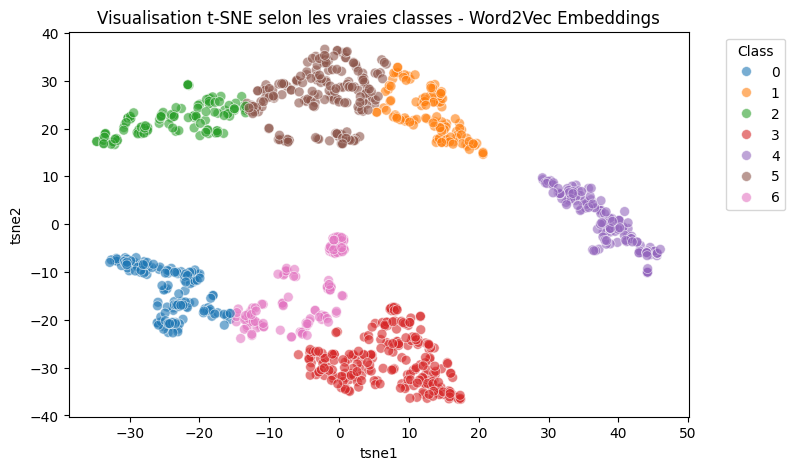

ARI :  0.19879820727556285


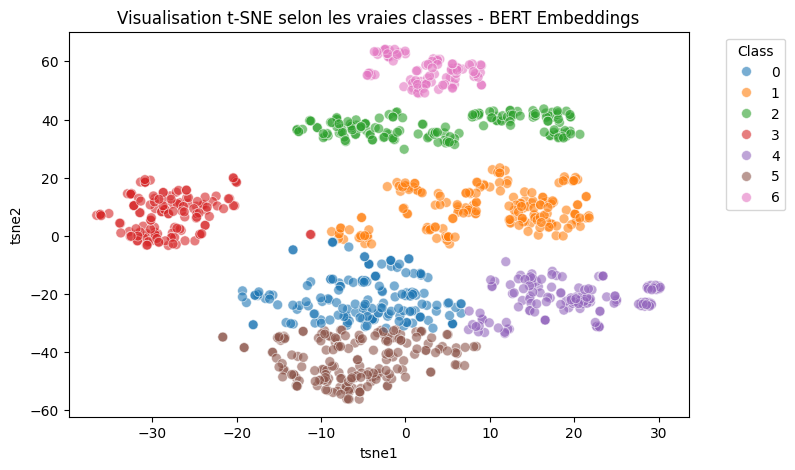

ARI :  0.3390530889757094


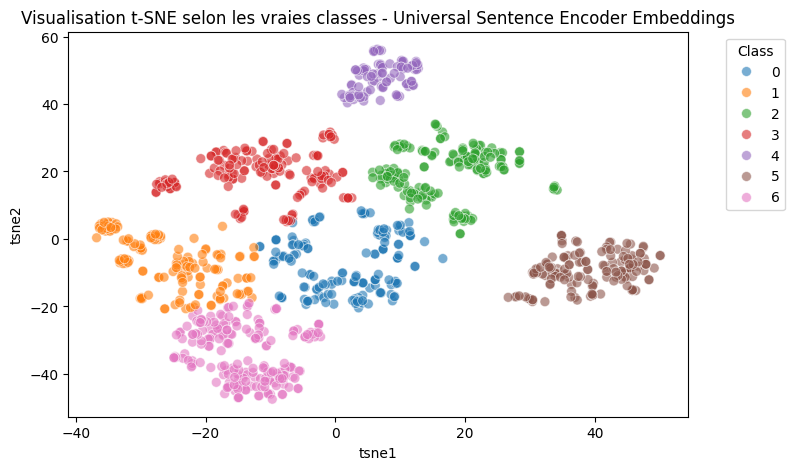

ARI :  0.42347785427505674


In [15]:
def cls_plot_tsne(X_tsne, df_tsne, cls, title):
  df_tsne["cluster"] = cls.labels_

  plt.figure(figsize=(8,5))
  sns.scatterplot(
      x="tsne1", y="tsne2",
      hue="cluster",
      palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
      data=df_tsne,
      legend="brief")

  plt.title(f'Visualisation t-SNE selon les vraies classes - {title}')
  plt.xlabel('tsne1')
  plt.ylabel('tsne2')
  plt.legend(title='Class', bbox_to_anchor=(1.05, 1), loc='upper left')

  plt.show()

  labels = data["label_main_category"]
  print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

# Tracer les graphiques t-SNE pour chaque matrice d'embeddings
cls_plot_tsne(wv_tsne, df_tsne_wv, cls_wv, 'Word2Vec Embeddings')
cls_plot_tsne(bert_tsne, df_tsne_bert, cls_bert, 'BERT Embeddings')
cls_plot_tsne(use_tsne, df_tsne_use, cls_use, 'Universal Sentence Encoder Embeddings')

### Analyse par classes

In [16]:
def conf_mat_gen(cls):
  labels = data["label_main_category"]
  conf_mat = metrics.confusion_matrix(labels, cls.labels_)
  print(conf_mat)

  return conf_mat
conf_mat_wv = conf_mat_gen(cls_wv)
conf_mat_bert = conf_mat_gen(cls_bert)
conf_mat_use = conf_mat_gen(cls_use)

[[ 80   8   6  20   0  22  14]
 [  3  24  59  41   0  18   5]
 [  1  24  37  41   0  33  14]
 [  8  37   6  51   0  33  15]
 [ 33   7  14  25   0  53  18]
 [  9  12   9  42   0  30  48]
 [  1   1   0   6 133   0   9]]
[[  5  13   8   5   9  97  13]
 [ 12  22  80   0  22  14   0]
 [ 62  18  68   2   0   0   0]
 [ 38  83   0   0  27   2   0]
 [  3   0   0   0   8  65  74]
 [ 32  49   3   0  61   4   1]
 [ 11   0   0 134   5   0   0]]
[[  8   3  12  14  13   0 100]
 [ 41   7  80  13   0   0   9]
 [ 79   0  71   0   0   0   0]
 [  9  50   0  82   0   0   9]
 [  3   0   0   0  74   0  73]
 [ 13  83   2  47   1   0   4]
 [  1   0   0   0   0 149   0]]


In [17]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)

    corresp = np.argmax(conf_mat, axis=0)
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x])

    return labels['y_pred_transform']

In [18]:
def cls_labels_transformer(cls):
  labels = data["label_main_category"]
  cls_labels_transform = conf_mat_transform(labels, cls.labels_)
  conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)
  print(conf_mat)
  print()
  print(metrics.classification_report(labels, cls_labels_transform))

  return conf_mat

conf_mat_wv = cls_labels_transformer(cls_wv)
conf_mat_bert = cls_labels_transformer(cls_bert)
conf_mat_use = cls_labels_transformer(cls_use)

Correspondance des clusters :  [0 3 1 3 6 4 5]
[[ 80   6   0  28  22  14   0]
 [  3  59   0  65  18   5   0]
 [  1  37   0  65  33  14   0]
 [  8   6   0  88  33  15   0]
 [ 33  14   0  32  53  18   0]
 [  9   9   0  54  30  48   0]
 [  1   0   0   7   0   9 133]]

              precision    recall  f1-score   support

           0       0.59      0.53      0.56       150
           1       0.45      0.39      0.42       150
           2       0.00      0.00      0.00       150
           3       0.26      0.59      0.36       150
           4       0.28      0.35      0.31       150
           5       0.39      0.32      0.35       150
           6       1.00      0.89      0.94       150

    accuracy                           0.44      1050
   macro avg       0.42      0.44      0.42      1050
weighted avg       0.42      0.44      0.42      1050

Correspondance des clusters :  [2 3 1 6 5 0 4]
[[ 97   8   5  13  13   9   5]
 [ 14  80  12  22   0  22   0]
 [  0  68  62  18   0   0   

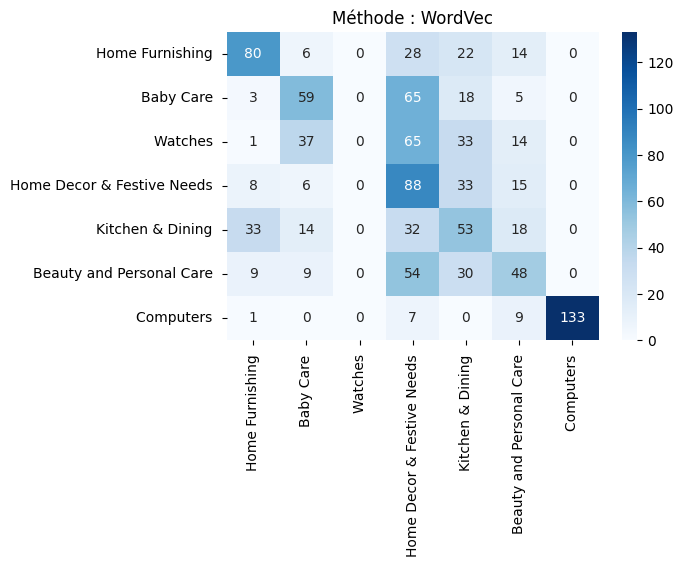

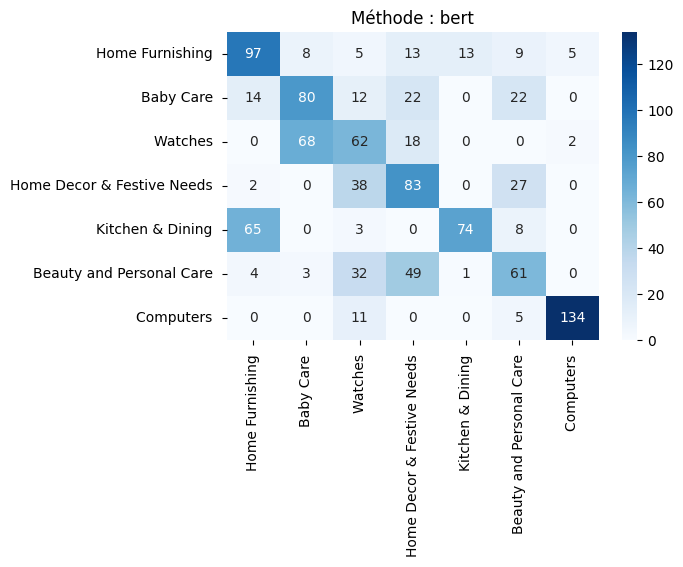

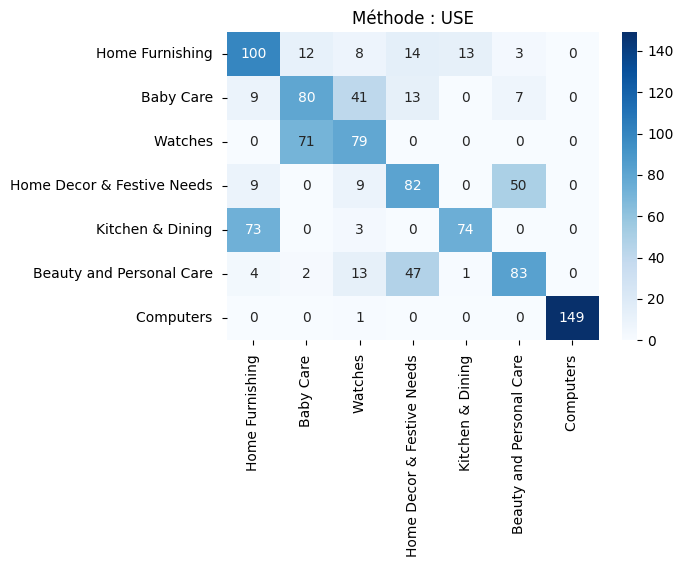

In [20]:
list_labels = data["main_category"].unique()

def matrice_conf_gen(conf_mat, title):

  df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                    columns = [i for i in list_labels])
  # Format des annotations
  fmt = 'd'
  plt.figure(figsize = (6,4))
  sns.heatmap(df_cm, annot=True, cmap="Blues", fmt=fmt)
  plt.title(f'Méthode : {title}')

matrice_conf_gen(conf_mat_wv, 'WordVec')
matrice_conf_gen(conf_mat_bert, 'bert')
matrice_conf_gen(conf_mat_use, 'USE')